# 🧠 Alzheimer's Disease Classification

**We recommend the use of a GPU Accelerator to reduce the load on the CPU and to run the notebook faster.**

In [18]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
print(tf.__version__)
print ("Usage of gpu: {}".format(tf.config.list_physical_devices())) 
print ("Built with CUDA: {}".format(tf.test.is_built_with_cuda()))

2.5.0
Usage of gpu: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: False


In [19]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
import tensorflow.keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

import pydot

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.5.0


### Importing the necessary libraries

### Data Pre-Processing

In [21]:
base_dir = "/Users/tarun/IIITN Project/ADNI/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['.DS_Store', 'Final MCI JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final AD JPEG', 'Final CN JPEG']


In [22]:
WORK_DIR = './dataset/'

CLASSES = [ 'Final AD JPEG',
            'Final CN JPEG',
            'Final EMCI JPEG',
            'Final LMCI JPEG',
            'Final MCI JPEG']

IMG_SIZE = 256
IMAGE_SIZE = [256, 256]
DIM = (IMG_SIZE, IMG_SIZE)

In [23]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 2614 images belonging to 5 classes.


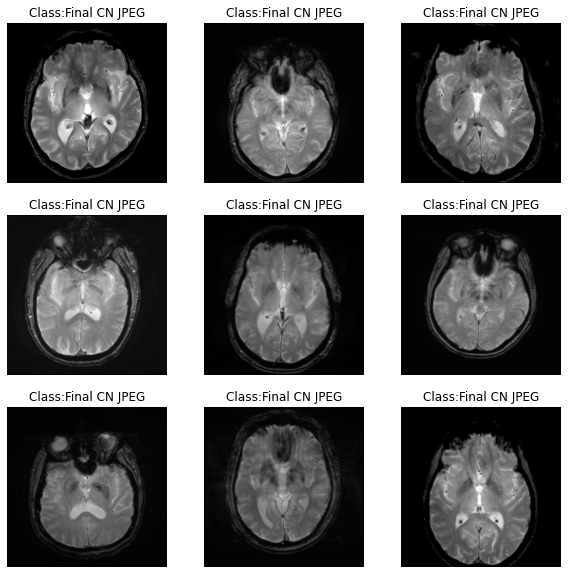

In [24]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1296)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [25]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [26]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(2614, 256, 256, 3) (2614, 5)


In [27]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(5800, 256, 256, 3) (5800, 5)


In [28]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [29]:
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(3712, 256, 256, 3) (1160, 256, 256, 3) (3712, 5) (1160, 5)


### Constructing a Convolutional Neural Network Architecture

In [30]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
        BatchNormalization(),
        Conv2D(32, 3, activation=act, padding='same'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
        BatchNormalization(),
        Conv2D(64, 3, activation=act, padding='same'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
        BatchNormalization(),
        Conv2D(128, 3, activation=act, padding='same'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(256, 3, activation=act, padding='same'),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.7),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')        
    ], name = "cnn_model")

    return model

model = construct_model()

In [31]:
model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18

In [32]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [33]:
#Defining other parameters for our CNN model



METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=5)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18

### Training & Testing the Model

In [34]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100


2022-02-07 12:46:01.244192: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-07 12:46:01.244719: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-07 12:46:01.635930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 4.6530 - acc: 0.2142 - auc: 0.5141 - f1_score: 0.2137

2022-02-07 12:46:29.841679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 32s 268ms/step - loss: 4.6530 - acc: 0.2142 - auc: 0.5141 - f1_score: 0.2137 - val_loss: 1.6173 - val_acc: 0.1961 - val_auc: 0.4885 - val_f1_score: 0.0656
Epoch 2/100
116/116 [==============================] - 31s 268ms/step - loss: 1.6713 - acc: 0.2236 - auc: 0.5325 - f1_score: 0.2228 - val_loss: 1.6299 - val_acc: 0.1843 - val_auc: 0.4895 - val_f1_score: 0.0622
Epoch 3/100
116/116 [==============================] - 31s 268ms/step - loss: 1.6250 - acc: 0.2209 - auc: 0.5310 - f1_score: 0.2184 - val_loss: 1.6106 - val_acc: 0.2015 - val_auc: 0.5055 - val_f1_score: 0.0671
Epoch 4/100
116/116 [==============================] - 31s 264ms/step - loss: 1.6132 - acc: 0.2260 - auc: 0.5400 - f1_score: 0.2197 - val_loss: 1.6149 - val_acc: 0.2188 - val_auc: 0.5129 - val_f1_score: 0.1324
Epoch 5/100
116/116 [==============================] - 31s 263ms/step - loss: 1.6291 - acc: 0.2166 - auc: 0.5305 - f1_score: 0.2155 - val_loss: 1.6071 - val_acc: 0.2015 - v

Epoch 40/100
116/116 [==============================] - 32s 273ms/step - loss: 0.1077 - acc: 0.9650 - auc: 0.9975 - f1_score: 0.9646 - val_loss: 0.3808 - val_acc: 0.8728 - val_auc: 0.9801 - val_f1_score: 0.8770
Epoch 41/100
116/116 [==============================] - 31s 269ms/step - loss: 0.1011 - acc: 0.9698 - auc: 0.9968 - f1_score: 0.9695 - val_loss: 0.3329 - val_acc: 0.8933 - val_auc: 0.9842 - val_f1_score: 0.8971
Epoch 42/100
116/116 [==============================] - 31s 267ms/step - loss: 0.1029 - acc: 0.9709 - auc: 0.9973 - f1_score: 0.9706 - val_loss: 0.3346 - val_acc: 0.8922 - val_auc: 0.9827 - val_f1_score: 0.8955
Epoch 43/100
116/116 [==============================] - 32s 280ms/step - loss: 0.0923 - acc: 0.9685 - auc: 0.9977 - f1_score: 0.9682 - val_loss: 0.3503 - val_acc: 0.8922 - val_auc: 0.9804 - val_f1_score: 0.8942
Epoch 44/100
116/116 [==============================] - 33s 281ms/step - loss: 0.0842 - acc: 0.9749 - auc: 0.9971 - f1_score: 0.9747 - val_loss: 0.3398 - va

Epoch 79/100
116/116 [==============================] - 31s 271ms/step - loss: 0.0624 - acc: 0.9836 - auc: 0.9984 - f1_score: 0.9834 - val_loss: 0.3158 - val_acc: 0.8879 - val_auc: 0.9873 - val_f1_score: 0.8912
Epoch 80/100
116/116 [==============================] - 31s 271ms/step - loss: 0.0651 - acc: 0.9814 - auc: 0.9987 - f1_score: 0.9812 - val_loss: 0.2779 - val_acc: 0.9095 - val_auc: 0.9882 - val_f1_score: 0.9131
Epoch 81/100
116/116 [==============================] - 33s 285ms/step - loss: 0.0204 - acc: 0.9938 - auc: 0.9996 - f1_score: 0.9937 - val_loss: 0.3067 - val_acc: 0.8944 - val_auc: 0.9885 - val_f1_score: 0.8967
Epoch 82/100
116/116 [==============================] - 34s 290ms/step - loss: 0.0156 - acc: 0.9962 - auc: 0.9995 - f1_score: 0.9962 - val_loss: 0.2940 - val_acc: 0.9213 - val_auc: 0.9852 - val_f1_score: 0.9240
Epoch 83/100
116/116 [==============================] - 35s 301ms/step - loss: 0.0297 - acc: 0.9943 - auc: 0.9991 - f1_score: 0.9943 - val_loss: 0.3056 - va

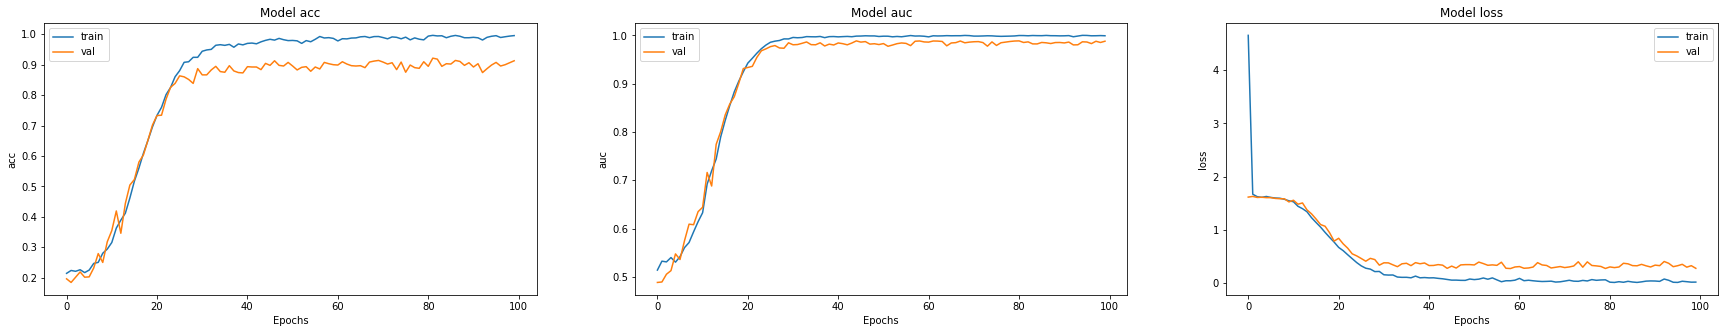

In [35]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [36]:
#Evaluating the model on the data

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

29/29 [==============================] - 3s 104ms/step - loss: 0.2806 - acc: 0.9127 - auc: 0.9878 - f1_score: 0.9154


2022-02-07 13:38:38.670445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 4s 108ms/step - loss: 0.3114 - acc: 0.9000 - auc: 0.9862 - f1_score: 0.9023
Training Accuracy: 100.00%
Validation Accuracy: 91.27%
Testing Accuracy: 90.00%


In [37]:
#Predicting the test data

pred_labels = model.predict(test_data)

2022-02-07 13:38:42.863676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [38]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                 precision    recall  f1-score   support

  Final AD JPEG       0.96      0.92      0.94       225
  Final CN JPEG       0.79      0.83      0.81       241
Final EMCI JPEG       0.87      0.92      0.89       230
Final LMCI JPEG       0.99      0.98      0.98       224
 Final MCI JPEG       0.92      0.86      0.89       240

      micro avg       0.90      0.90      0.90      1160
      macro avg       0.90      0.90      0.90      1160
   weighted avg       0.90      0.90      0.90      1160
    samples avg       0.90      0.90      0.90      1160



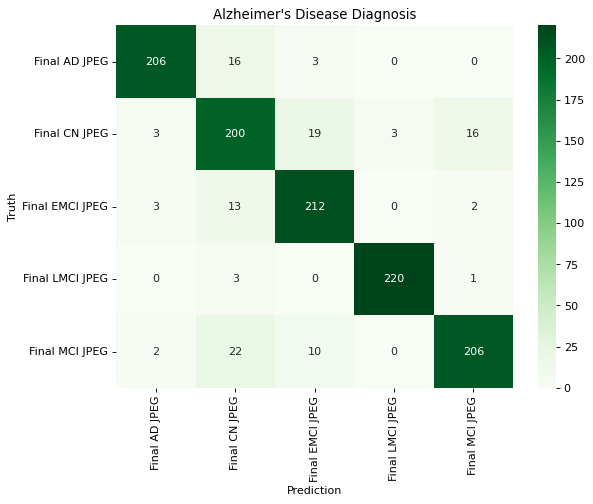

In [39]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [40]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 90.15 %
Matthew's Correlation Coefficient: 87.53 %


In [41]:
#Saving the model for future use

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['.DS_Store',
 'Final MCI JPEG',
 'alzheimer_cnn_model',
 'Final EMCI JPEG',
 'Final LMCI JPEG',
 'Final AD JPEG',
 'Final CN JPEG']

In [42]:
pretrained_model = tf.keras.models.load_model(model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

NameError: name 'plot_model' is not defined

### Using the InceptionV3 model as a base model for the task

**Please check out the notebook here: 
[Inception V3 Model Notebook](https://www.kaggle.com/vishakansubramanian/alzheimer-s-disease-classification-inceptionv3)**